# **CIS 545 Final Project**
Stacey Chen and Fred Choi

“How could you lose with such a great horse?” As Gi-hun discovered in Squid Games, horse racing can seem unpredictable. Sometimes, the favorite will win, and sometimes, a dark horse takes the grand prize. With so many factors that affect the outcome of a horse race, Big Data can help to analyze, understand, and demystify the process.

Having both grown up within an hour’s drive of Hong Kong’s racing scene, we have been fascinated by the horse races held there. Hong Kong’s horse racing organization, the Hong Kong Jockey Club (HKJC) is one of the largest in the world. With billions of dollars of betting turnover each year, the HKJC is actually Hong Kong’s largest single taxpayer, contributing to 11.7% of the city’s yearly tax revenue.

In this project, we plan to use publicly available data on the HKJC’s website, which will be scraped using Selenium and stored in CSV format. Following the data acquisition process, we will clean and wrangle the data and apply various forms of analysis that we have learnt throughout this class.

# Data Acquisition

We decided to use a full season’s worth of horse racing data from the 2020-2021 season. Each season has 88 total race days, with each race day consisting of approximately 10 races on average. As such, we collected around 880 races worth of data. We store the list of dates and each race date’s location (HKJC has 2 race venues) in races.txt. HKJC’s website contains various data points for each race, including historical data for each horse’s performance. We can see the data available in the image below.

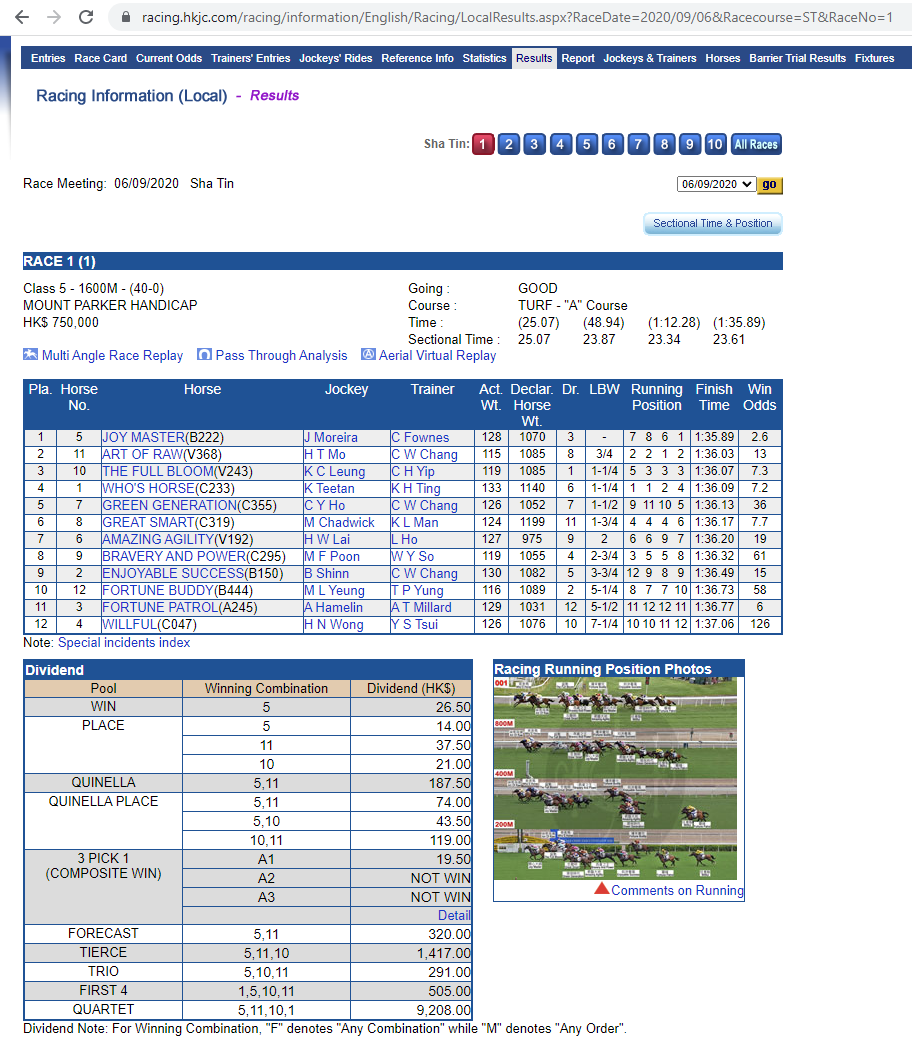

Figure 1: HKJC’s webpage for a race.

We access this page by generating the URL shown above using the race date and venue from races.txt. Next, we check how many races were held on this race date. We achieve this by using Selenium and inputting the XPATH for the table showing the race numbers (1 to 10 in the case above) and using the table length to calculate the number of races. We can then modify the last component of the URL (RaceNo=””) to check the data from a specific race. To obtain race data from this webpage, we used Selenium to find elements by XPATHs. Such elements included general information about the race, such as its class, distance and going, and all data points within the first table. In the table, there is information about the horse, jockey and trainer etc., and for each horse, our script follows the URL link in the 3rd column to extract more information about the horse, including its rating and how much money (stakes) it has won this year. Unfortunately, since we ran into issues using Selenium on Google Colab, we had to run our data acquisition program using VS Code locally on our own devices. **The code we developed for this process is attached in the submission as data_scraper.py.**

Following the data acquisition, we generated 2 CSV files. The first CSV is called combined_horse_data, and is where our python script dumps data for each horse after clicking into the horse’s URL for each horse in the race. Our second CSV is called combined_race data and contains all the relevant information from the webpage shown in Fig. 1.


# Data Wrangling and Cleaning



We uploaded our CSV files to an open repository on Github, allowing for easy access with Pandas in Python.

In [ ]:
import pandas as pd


horse_url = "https://raw.githubusercontent.com/fredkychoi/CIS-545-Final-Project/main/combined_horse_data.csv"
race_url = "https://raw.githubusercontent.com/fredkychoi/CIS-545-Final-Project/main/combined_race_data.csv"

horse_df = pd.read_csv(horse_url)
race_df = pd.read_csv(race_url)
race_df

race_df

,Date,Loc.,Race No.,Type,Going,Course,Purse,Place,No.,Horse,Jockey,Trainer,Act. Wt.,Decl. Horse Wt.,Draw,LBW,Running Pos.,Finish Time,Win Odds
0,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",1,5.0,JOY MASTER(B222),J Moreira,C Fownes,128,1070,3,"""-""",7 8 6 1,01:35.9,2.6
1,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",2,11.0,ART OF RAW(V368),H T Mo,C W Chang,115,1085,8,"""3/4""",2 2 1 2,01:36.0,13
2,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",3,10.0,THE FULL BLOOM(V243),K C Leung,C H Yip,119,1085,1,"""1-1/4""",5 3 3 3,01:36.1,7.3
3,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",4,1.0,WHO'S HORSE(C233),K Teetan,K H Ting,133,1140,6,"""1-1/4""",1 1 2 4,01:36.1,7.2
4,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",5,7.0,GREEN GENERATION(C355),C Y Ho,C W Chang,126,1052,7,"""1-1/2""",9 11 10 5,01:36.1,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10289,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",8,2.0,AMAZING ONE PLUS(D173),A Hamelin,T P Yung,130,1141,10,"""3-1/4""",8 8 8,01:09.1,149
10290,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",9,1.0,GOLDEN DASH(B190),H Bentley,C S Shum,133,1089,12,"""3-1/4""",11 11 9,01:09.1,57
10291,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",10,11.0,WAR WEAPON(E257),K Teetan,C Fownes,114,1150,1,"""4-1/2""",4 4 10,01:09.3,5.4
10292,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",11,12.0,BABY(C271),V Borges,K H Ting,113,1155,6,"""6-3/4""",7 7 11,01:09.7,40


Since we added an entry to combined_horse_data.csv every time it appeared in a race table, there must be duplicates of horse data in combined_horse_data.csv as horses run multiple races in a season. As such, we first remove duplicate entries in horse_df. Next, we drop the data columns consisting of each horse’s sire, dam, dam’s sire and stable location, as these variables were deemed to be less significant factors in race outcomes.

In [ ]:
# Drop duplicates
horse_df = horse_df.drop_duplicates()

# Drop parents, stable_location
horse_df = horse_df.drop(['sire', 'dam', 'dam_sire', 'stable_loc'], axis=1)
horse_df

,horse_name,horse_url,country_of_origin,age,color,sex,import_type,season_stakes,total_stakes,no_123_starts,no_starts_in_10,trainer,owner,current_rating,sos_rating,retired
0,JOY MASTER(B222),https://racing.hkjc.com/racing/information/Eng...,AUS,7,Bay,Gelding,PP,"$124,800","$2,590,670",4-1-3-45,2,D E Ferraris,"Fong Chi Keung, Chan Chu Woon & Tam Kin Sang",40,44,False
1,ART OF RAW(V368),https://racing.hkjc.com/racing/information/Eng...,FR,-1,Bay,Gelding,PP,NaN,"$1,264,425",1-3-1-38,-1,NaN,Mr & Mrs Chan Chi Kong,23,-1,True
2,THE FULL BLOOM(V243),https://racing.hkjc.com/racing/information/Eng...,GB,-1,NaN,NaN,PP,NaN,"$3,760,725",6-1-5-76,-1,NaN,Gary Lee Sai Ho,20,-1,True
3,WHO'S HORSE(C233),https://racing.hkjc.com/racing/information/Eng...,NZ,6,Bay,Gelding,PPG,$0,"$225,955",0-0-1-19,1,W Y So,Frederick Ma Si Hang & Eric Tsang Chi Wai,17,24,False
4,GREEN GENERATION(C355),https://racing.hkjc.com/racing/information/Eng...,NZ,-1,Chestnut,Gelding,PPG,NaN,"$392,875",0-1-1-14,-1,NaN,One More Round Syndicate,27,-1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10007,BRILLIANT LIFE(E396),https://racing.hkjc.com/racing/information/Eng...,NZ,4,Brown,Gelding,PP,"$94,200","$94,200",0-0-0-3,0,C H Yip,Timothy Chan Chi Kin,64,66,False
10092,I BELIEVE IN MAGIC(E200),https://racing.hkjc.com/racing/information/Eng...,IRE,4,Bay,Gelding,PPG,$0,$0,0-0-0-3,2,P O'Sullivan,Kitty Yeung Au Nim Bing,45,51,False
10138,SAUVESTRE(E315),https://racing.hkjc.com/racing/information/Eng...,AUS,4,Bay,Gelding,PP,"$525,950","$525,950",0-1-1-3,1,F C Lor,Jackson So Hoi Wing,71,68,False
10167,WIN WIN FIGHTER(E347),https://racing.hkjc.com/racing/information/Eng...,IRE,3,Bay,Gelding,PP,$0,$0,0-0-0-3,1,K W Lui,Ho Pui Wai,66,70,False


As we can see in the last few rows in the horese_df dataframe output above, some column data is shifted to the left. For example in rows 7582 and 7583 we can see the data for “no_123_starts” is NaN, with the actual correct value in the column on the left. After the data acquisition process, we realized that some horse webpages had data ordered differently, causing the columns to look “shifted” for some rows. As such, the next code cell corrects this issue by fixing the columns of the problematic rows.

In [ ]:
# shift season_stakes, total_stakes, and trainer to the right, if data is messed up
for index, row in horse_df.iterrows():
  # print(row)
  for k, v in row.items():
    # print(x)
    if k == 'total_stakes' and '-' in str(v):
      horse_df.loc[index:index,['season_stakes','total_stakes','no_123_starts']] = horse_df.loc[index:index,['season_stakes','total_stakes','no_123_starts']].shift(1,axis=1)
      horse_df.loc[index:index,['trainer', 'owner']] = horse_df.loc[index:index,['trainer', 'owner']].shift(1,axis=1)


Now that all the data in horse_df is in the right location, we will change the types of the variables season stakes and total stakes. These values were depicted as strings with dollar signs and commas on the HKJC website, and we reformat them to integer type below. In addition, all null values in the respective columns are replaced with 0.

In [ ]:
# replace dollar sign with integer in season_stakes and total_stakes, replace NaN to 0
horse_df['season_stakes'] = horse_df['season_stakes'].str.replace(',', '').str.replace('$', '').fillna(0).astype(int)
horse_df['total_stakes'] = horse_df['total_stakes'].str.replace(',', '').str.replace('$', '').fillna(0).astype(int)


Note that the column “no_123_starts” contains 4 integer values. This variable contains the count of 1st place, 2nd place, 3rd place finishes and race starts respectively. That is, if a horse has value “2-1-2-13” in “no_123_starts”, this means that the horse has raced 13 times, of which it has come in first place twice, second place once, and third place two times. In the code cell below, we create 4 new columns to “explode” the data and store the values as an integer.

In [ ]:
# explode no_123_starts into 4 columns
no_123_starts = horse_df['no_123_starts']
horse_df[['no_1', 'no_2', 'no_3', 'no_starts']] = no_123_starts.str.split("-", n=3, expand=True)
horse_df

,horse_name,horse_url,country_of_origin,age,color,sex,import_type,season_stakes,total_stakes,no_123_starts,no_starts_in_10,trainer,owner,current_rating,sos_rating,retired,no_1,no_2,no_3,no_starts
0,JOY MASTER(B222),https://racing.hkjc.com/racing/information/Eng...,AUS,7,Bay,Gelding,PP,124800,2590670,4-1-3-45,2,D E Ferraris,"Fong Chi Keung, Chan Chu Woon & Tam Kin Sang",40,44,False,4,1,3,45
1,ART OF RAW(V368),https://racing.hkjc.com/racing/information/Eng...,FR,-1,Bay,Gelding,PP,0,1264425,1-3-1-38,-1,NaN,Mr & Mrs Chan Chi Kong,23,-1,True,1,3,1,38
2,THE FULL BLOOM(V243),https://racing.hkjc.com/racing/information/Eng...,GB,-1,NaN,NaN,PP,0,3760725,6-1-5-76,-1,NaN,Gary Lee Sai Ho,20,-1,True,6,1,5,76
3,WHO'S HORSE(C233),https://racing.hkjc.com/racing/information/Eng...,NZ,6,Bay,Gelding,PPG,0,225955,0-0-1-19,1,W Y So,Frederick Ma Si Hang & Eric Tsang Chi Wai,17,24,False,0,0,1,19
4,GREEN GENERATION(C355),https://racing.hkjc.com/racing/information/Eng...,NZ,-1,Chestnut,Gelding,PPG,0,392875,0-1-1-14,-1,NaN,One More Round Syndicate,27,-1,True,0,1,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10007,BRILLIANT LIFE(E396),https://racing.hkjc.com/racing/information/Eng...,NZ,4,Brown,Gelding,PP,94200,94200,0-0-0-3,0,C H Yip,Timothy Chan Chi Kin,64,66,False,0,0,0,3
10092,I BELIEVE IN MAGIC(E200),https://racing.hkjc.com/racing/information/Eng...,IRE,4,Bay,Gelding,PPG,0,0,0-0-0-3,2,P O'Sullivan,Kitty Yeung Au Nim Bing,45,51,False,0,0,0,3
10138,SAUVESTRE(E315),https://racing.hkjc.com/racing/information/Eng...,AUS,4,Bay,Gelding,PP,525950,525950,0-1-1-3,1,F C Lor,Jackson So Hoi Wing,71,68,False,0,1,1,3
10167,WIN WIN FIGHTER(E347),https://racing.hkjc.com/racing/information/Eng...,IRE,3,Bay,Gelding,PP,0,0,0-0-0-3,1,K W Lui,Ho Pui Wai,66,70,False,0,0,0,3


We now move on to the race_df dataframe. We first drop the column “purse”, which is the total prize money for the race.

In [ ]:
# Drop purse
race_df = race_df.drop(['Purse'], axis=1)

Next, we convert numerical values in the columns of race_df into float values. However, there are cases where the value in the place column is not fully numerical. One example occurs when two horses finish the race extremely closely and their finishing order cannot be determined - i.e. to the highest level of accuracy available to HKJC, they finish at the same time. This event is known as a “dead heat” and the horses are declared to have tied for a certain place. In this event, the notation “DH” is added to the race table data. As such, we must remove the DH string first before converting the values to integers. In addition, horses can occasionally withdraw or be pulled out of races. In this case, their “place” value will be marked by a special acronymical code for the reason why they did not finish the race. Since we do not care too much about these events as they occur extremely rarely, and they are almost impossible to predict, we remove all such rows where horses don’t finish from the race_df dataframe.

In [ ]:
# Convert place, weight, decl. horse. wt., draw, Win Odds to integer
race_df = pd.read_csv(race_url)
for index, row in race_df.iterrows():
  # DH - dead heat, take the integer
  # WV/WX/UR - withdraw
  place = row['Place']
  if (not place.isnumeric()):
    if ('DH' in place):
      race_df.at[index, 'Place'] = int(place.strip().split(' ')[0])
    else:
      race_df.drop(index, inplace=True)
race_df = race_df.astype({'Place': 'float'})
race_df = race_df.astype({'Act. Wt.': 'float'})
race_df = race_df.astype({'Decl. Horse Wt.': 'float'})
race_df = race_df.astype({'Draw': 'float'})
race_df = race_df.astype({'Win Odds': 'float'})


Note that the column “Running Pos.” contains multiple integer values. This variable consists of the horses’ running position for each 400 meters of the race, inclusive of the final position of the race. That is, if a horse entered a 1000 meter race, it will have a running position value for the of “x-y-z” where x, y, and z are integers and x is horse’s place after the first 400 meters, y after the first 800 meters and z is the horse’s position after the completion of the race. Since race distances vary drastically, we decided against creating multiple new columns in the dataframe which could potentially be left empty in shorter race distances, and we instead chose to replace the column value with the average race position of the horse, which was taken as the mean of all integers found in each cell in the column. In the code cell below, we replace the running position column values with their respective means.

In [ ]:
from statistics import mean
# Explode pos. split into four quarters
race_df['Running Pos.'] = race_df['Running Pos.'].apply(lambda x: mean([int(i) for i in x.split(' ')])) 
race_df['Running Pos.'] 

0         5.500000
1         1.750000
2         3.500000
3         2.000000
4         8.750000
           ...    
10289     8.000000
10290    10.333333
10291     6.000000
10292     8.333333
10293    10.666667
Name: Running Pos., Length: 10163, dtype: float64

Next, we convert the column finish time from the format MM:SS.xx where MM is minutes, SS is seconds and xx follows the decimal place for seconds, to seconds only. This will allow us to store the values in this column as an integer.

In [ ]:
# Convert finish time to seconds
for index, row in race_df.iterrows():
  time = row['Finish Time'].split(':')
  min = int(time[0])
  sec = float(time[1])
  total = min * 60 + sec
  race_df.at[index, 'Finish Time'] = total


Following this step, we create new columns in race_df for the 3 different variables stored within the Type column, which include the class of the race, the race distance and the race rating (max and min ratings of the horses present). In addition, we also create two new columns for the maximum and minimum horse ratings in the race. If there is no max rating, 150 is filled in as this was estimated to be an upper limit for the rating that most horses can achieve, whilst 0 is filled in for null minimum rating values.


In [ ]:
# Distance
# Explode Type into Class, Distance, Rating
race_type = race_df['Type']
race_df[['Type Class', 'Type Distance', 'Type Rating']] = race_type.str.split("-", n=2, expand=True)
# Convert distance to float
race_df['Type Distance'] = race_df['Type Distance'].str.replace('M', '')
race_df = race_df.astype({'Type Distance': 'float'})
race_rating = race_df['Type Rating']
race_df[['Max Rating', 'Min Rating']] = race_rating.str.split("-", expand=True)
race_df['Max Rating'] = race_df['Max Rating'].str.replace('(', '')
race_df['Max Rating'] = race_df['Max Rating'].str.replace(')', '')
race_df['Min Rating'] = race_df['Min Rating'].str.replace(')', '')
race_df['Min Rating'] = race_df['Min Rating'].fillna(race_df['Max Rating'])
race_df['Max Rating'] = race_df['Max Rating'].apply(lambda x: '150' if x is not None and '+' in x else x)
race_df['Min Rating'] = race_df['Min Rating'].str.replace('+', '')
race_df = race_df.astype({'Max Rating': 'float'})
race_df = race_df.astype({'Min Rating': 'float'})
race_df['Max Rating'] = race_df['Max Rating'].fillna(150)
race_df['Min Rating'] = race_df['Min Rating'].fillna(0)


In addition, we create a new column variable which shows the horse’s running pace for a race by dividing the race distance by the horse’s finish time.

In [ ]:
# Add column pace: distance over time
print(race_df.dtypes)

race_df['Pace'] = race_df['Type Distance']/race_df['Finish Time']
race_df

Date                object
Loc.                object
Race No.             int64
Type                object
Going               object
Course              object
Purse               object
Place              float64
No.                float64
Horse               object
Jockey              object
Trainer             object
Act. Wt.           float64
Decl. Horse Wt.    float64
Draw               float64
LBW                 object
Running Pos.       float64
Finish Time         object
Win Odds           float64
Type Class          object
Type Distance      float64
Type Rating         object
Max Rating         float64
Min Rating         float64
dtype: object


,Date,Loc.,Race No.,Type,Going,Course,Purse,Place,No.,Horse,Jockey,Trainer,Act. Wt.,Decl. Horse Wt.,Draw,LBW,Running Pos.,Finish Time,Win Odds,Type Class,Type Distance,Type Rating,Max Rating,Min Rating,Pace
0,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",1.0,5.0,JOY MASTER(B222),J Moreira,C Fownes,128.0,1070.0,3.0,"""-""",5.500000,95.9,2.6,Class 5,1600.0,(40-0),40.0,0.0,16.684
1,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",2.0,11.0,ART OF RAW(V368),H T Mo,C W Chang,115.0,1085.0,8.0,"""3/4""",1.750000,96,13.0,Class 5,1600.0,(40-0),40.0,0.0,16.6667
2,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",3.0,10.0,THE FULL BLOOM(V243),K C Leung,C H Yip,119.0,1085.0,1.0,"""1-1/4""",3.500000,96.1,7.3,Class 5,1600.0,(40-0),40.0,0.0,16.6493
3,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",4.0,1.0,WHO'S HORSE(C233),K Teetan,K H Ting,133.0,1140.0,6.0,"""1-1/4""",2.000000,96.1,7.2,Class 5,1600.0,(40-0),40.0,0.0,16.6493
4,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",5.0,7.0,GREEN GENERATION(C355),C Y Ho,C W Chang,126.0,1052.0,7.0,"""1-1/2""",8.750000,96.1,36.0,Class 5,1600.0,(40-0),40.0,0.0,16.6493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10289,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",8.0,2.0,AMAZING ONE PLUS(D173),A Hamelin,T P Yung,130.0,1141.0,10.0,"""3-1/4""",8.000000,69.1,149.0,Class 2,1200.0,(90-70),90.0,70.0,17.3661
10290,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",9.0,1.0,GOLDEN DASH(B190),H Bentley,C S Shum,133.0,1089.0,12.0,"""3-1/4""",10.333333,69.1,57.0,Class 2,1200.0,(90-70),90.0,70.0,17.3661
10291,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",10.0,11.0,WAR WEAPON(E257),K Teetan,C Fownes,114.0,1150.0,1.0,"""4-1/2""",6.000000,69.3,5.4,Class 2,1200.0,(90-70),90.0,70.0,17.316
10292,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",11.0,12.0,BABY(C271),V Borges,K H Ting,113.0,1155.0,6.0,"""6-3/4""",8.333333,69.7,40.0,Class 2,1200.0,(90-70),90.0,70.0,17.2166


Finally, we save the resulting horse_df and race_df dataframes to CSV files within our local drive to allow for convenient access by our models in later stages of the project.

In [ ]:
from google.colab import drive
drive.mount('/drive')
# Output to CSV (Stacey's Version)
# horse_df.to_csv('/drive/My Drive/Senior/CIS545/CIS545_Final_Project/clean_horse_data.csv')
# race_df.to_csv('/drive/My Drive/Senior/CIS545/CIS545_Final_Project/clean_race_data.csv')

# Output to CSV (Fred's Version)
horse_df.to_csv("/drive/MyDrive/CIS 545 Final Project/clean_horse_data.csv")
race_df.to_csv("/drive/MyDrive/CIS 545 Final Project/clean_race_data.csv")


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Exploratory Data Analysis

We first load in the CSV files saved in our Google Drive from the Data Wrangling and Cleaning stage of the project.

In [ ]:
from google.colab import drive
drive.mount('/drive')

# Read CSV (Stacey's Version)
# horse_df = pd.read_csv('/drive/My Drive/Senior/CIS545/CIS545_Final_Project/clean_horse_data.csv')
# race_df = pd.read_csv('/drive/My Drive/Senior/CIS545/CIS545_Final_Project/clean_race_data.csv')

# Read CSV (Fred's Version)
horse_df = pd.read_csv("/drive/MyDrive/CIS 545 Final Project/clean_horse_data.csv")
race_df = pd.read_csv("/drive/MyDrive/CIS 545 Final Project/clean_race_data.csv")
print("horse_df datatypes:")
print(horse_df.dtypes)
print("\nrace_df datatypes:")
print(race_df.dtypes)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
horse_df datatypes:
Unnamed: 0            int64
horse_name           object
horse_url            object
country_of_origin    object
age                   int64
color                object
sex                  object
import_type          object
season_stakes         int64
total_stakes          int64
no_123_starts        object
no_starts_in_10       int64
trainer              object
owner                object
current_rating        int64
sos_rating            int64
retired                bool
no_1                  int64
no_2                  int64
no_3                  int64
no_starts             int64
dtype: object

race_df datatypes:
Unnamed: 0           int64
Date                object
Loc.                object
Race No.             int64
Type                object
Going               object
Course              object
Purse               object
Place              float64
No

Having cleaned the data, we first want to do some Exploratory Data Analysis, or EDA. We were first curious about the horse rating system that HKJC uses, and whether a higher horse rating actually corresponds with a greater number of wins compared to starts. This is because horses compete in races within a specific horse rating range, e.g. 40-60, where 40 is the minimum rating required to compete and 60 is the maximum. As such, we create a plot below of all horses’ win ratio vs. current rating.

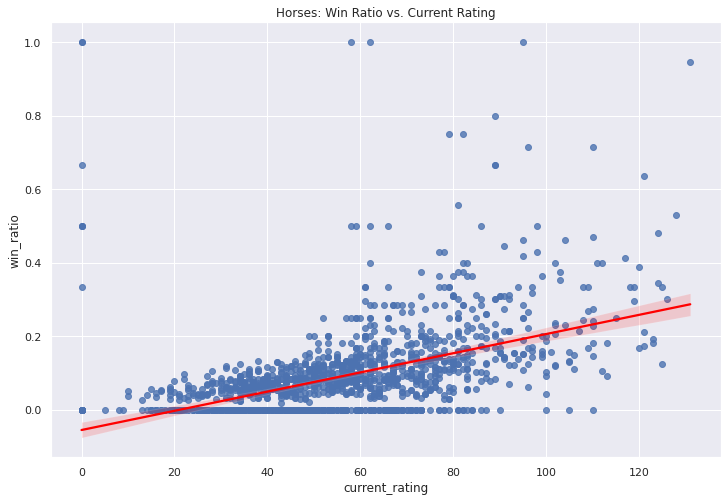

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
plt.figure(figsize = (12,8))
plt.title("Horses: Win Ratio vs. Current Rating")
horse_df['win_ratio'] = horse_df['no_1'] / horse_df['no_starts']
horse_df['win_ratio'] = horse_df['win_ratio'].fillna(0)
ax = sns.regplot(x="current_rating", y="win_ratio", data=horse_df,line_kws={'color':'red'})

We can see that there is in fact a correlation between win ratio and current rating, however, the correlation is not as strong as we initially thought. In addition to a couple outliers, there are numerous horses with high ratings that have never won a race. Despite this, the plot above clearly shows that a horse’s current rating can help our models to predict the probability of a horse winning a race, and is thus an important variable in our data analysis.

Next, we create a heat map showing the correlation between features in horse_df.

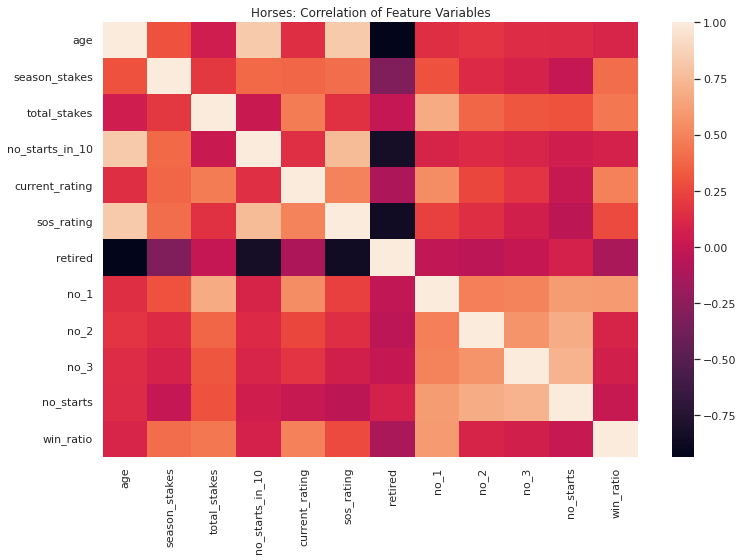

In [ ]:
# Correlation Matrix
unnumbered_horse_df = horse_df.drop(['Unnamed: 0'], axis=1)
horse_corr = unnumbered_horse_df.corr()

# Heatmap
plt.figure(figsize = (12,8))
plt.title("Horses: Correlation of Feature Variables")
dataplot = sns.heatmap(horse_corr, annot=False)
plt.show()

One key variable that we would like to further explore in our predictions is the win odds of a horse in a race. Win odds are the dividend multiplier paid out if a bet is made on the horse to win. For instance, if a horse had win odds of 2.5 and a person bets \$10 on the horse to win, they would receive \$25 if the horse wins the race. The win odds shown on the HKJC’s website are recorded the instance that the race starts, meaning that theoretically there would be insufficient time to pass these variables into a model with enough time to make a bet. Why do we want the most updated win odds? This is because the win odds are influenced by how many bets are placed on the horses in the race. People are allowed to bet on horses up until the start of the race, and many people take into account real time factors such as the horse’s composure and posture leading up to the race to make their betting decisions. As such, projected win odds could be utilized as a powerful tool to leverage the expertise and consensus of the general population. Therefore, one of the aims of our project will be to try and predict the average win odds of horses in horse_df.

We first explore the importance of win odds in predicting a race winner. In our races_df, we will group by race, and check whether the horse with the lowest win odds has indeed finished in first place. In the code cell below, we will create a count of the number of horses that won with the lowest win odds, the second lowest win odds, and the third lowest win odds etc.

In [ ]:
# Helper function to check the win odd rank of the horse that won the race
def check_order(race_odds, winner_odds):
  i = 0
  
  for odd in race_odds:
    if odd == winner_odds:
      return i
    else:
      i += 1

# List of horses that had the lowest, second lowest, third lowest win odds etc.
counts = [0] * 15;

for name, group in race_df.groupby("Date"):
  for name1, group1 in group.groupby("Race No."):
    group1 = group1.sort_values(by="Place", ascending=True)
    race_odds = group1["Win Odds"].tolist()
    race_odds.sort()
    winner_odds = group1["Win Odds"].iloc[0]
    order = check_order(race_odds, winner_odds)
    counts[order] += 1

print(counts)
print("Total Races: " + str(sum(counts)))

[260, 133, 103, 93, 76, 56, 39, 26, 20, 16, 7, 1, 2, 1, 0]
Total Races: 833


We can visualize the data with a bar plot generated by the code cell below.

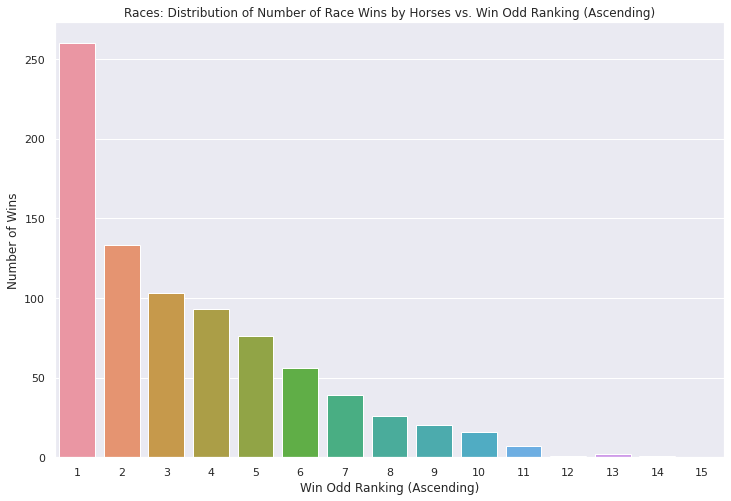

In [ ]:
plt.figure(figsize = (12,8))
plt.title("Races: Distribution of Number of Race Wins by Horses vs. Win Odd Ranking (Ascending)")
plt.xlabel("Win Odd Ranking (Ascending)")
plt.ylabel("Number of Wins")
orderings = list(range(1, 16))
sns.barplot(x=orderings, y=counts)

The plot shows that the horse with the lowest win odds is by far most likely to win a race. In fact, over the 2020-2021 season, the horse with the lowest win odds won their respective races 260 out of 833 total races, or approximately 31%. Horses with increasing rankings of win odds will have significantly lower chances of winning a race. This emphasizes the importance of win odds as a variable, which is directly influenced by the “vote” of the general public, in predicting the outcome of horse races. 

# Data Analysis and Modeling

## Linear Regression
We now commence the data analysis stage of our project. As mentioned above, win odds are an extremely important factor in predicting the outcome of horse races. We will attempt to reach a solution using simple linear regression tools with sklearn to predict the average win odds of a horse, which we could use to make predictions by comparing with the values of different horses in the same race.

In [ ]:
horse_df['avg_win_odds'] = 1000.0

for name, group in race_df.groupby("Horse"):
  avg_wo = group["Win Odds"].mean()
  horse_df.loc[horse_df["horse_name"] == name, "avg_win_odds"] = avg_wo
  

First, we start encoding the trainer of each horse. In the code cell below, we have a list of trainers with descending orders of wins over the previous season. That is, F C Lor had the most wins, followed by J Size etc. We then assign these rankings as a new column in horse_df named “trainer_rank”.

In [ ]:
trainers = ["F C Lor", "J Size", "A S Cruz", "D A Hayes", "K W Lui", "K H Ting", "C S Shum", "K L Man", "D J Whyte", "T P Yung", "D J Hall", "C Fownes", "C H Yip", "W Y So", "P F Yiu", "A T Millard", "Y S Tsui", "C W Chang", "D E Ferraris", "R Gibson", "L Ho", "P O'Sullivan", "Y Yahagi", "T Ozeki", "N Hori", "T Matsushita", "W Muir", "de Royer Dupre", "W J Haggas", "A P O'Brien", "H Otonashi", "H Fujiwara", "J S Bolger", "K Hagiwara", "T Takano", "T Yasuda"]
i = 0
horse_df['trainer_rank'] = 36

for trainer in trainers:
  horse_df.loc[horse_df["trainer"] == trainer, "trainer_rank"] = i
  i += 1
  

Next, when training our linear regression model, we create a new dataframe called new_horse_df. Here, we remove all retired horses. This is because when we obtain extra data on horses in horse_df, the information has been updated to this season’s information. This means that there are numerous horses that raced in our data set that are currently marked as retired, and have 0 seaon’s stakes and 0 starts in the last 10 races. As such, we must drop these horses for our model’s training data. In addition, since the HKJC website does not show data for retired horses’ age and, we are forced to remove this variable as we cannot simply fill in a retired horse’s age with null/0 or 10 as the age of retired horses can vary significantly. Furthermore, we also drop variables that are hard to encode for our linear regression model, such as the horse name and country of origin.

In [ ]:
new_horse_df = horse_df[horse_df['retired'] == False]
new_horse_df = new_horse_df.drop(columns=['age', 'horse_name', 'Unnamed: 0', 'horse_url', 'no_123_starts', 'trainer', 'retired', 'country_of_origin', 'color', 'sex', 'import_type', 'owner'])


The resulting dataframe new_horse_df is shown below.

In [ ]:
new_horse_df

,season_stakes,total_stakes,no_starts_in_10,current_rating,sos_rating,no_1,no_2,no_3,no_starts,win_ratio,avg_win_odds,trainer_rank
0,124800,2590670,2,40,44,4,1,3,45,0.088889,11.588889,18
3,0,225955,1,17,24,0,0,1,19,0.000000,14.783333,13
10,0,1833855,1,27,27,2,2,6,47,0.042553,10.658333,15
13,0,855000,1,32,33,1,2,0,18,0.055556,10.433333,11
15,117000,2216800,1,35,34,3,2,5,40,0.075000,24.446154,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1609,94200,94200,0,64,66,0,0,0,3,0.000000,87.000000,12
1610,0,0,2,45,51,0,0,0,3,0.000000,172.000000,21
1611,525950,525950,1,71,68,0,1,1,3,0.000000,15.000000,0
1612,0,0,1,66,70,0,0,0,3,0.000000,87.000000,4


Next, we split this dataframe into features and labels.

In [ ]:
label = new_horse_df['avg_win_odds']
features = new_horse_df.copy().drop(columns = 'avg_win_odds')
print(len(features))

1080


Then we split the data into training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.20)


Following this step, we train our linear regression model using sklearn and analyze the results using mean squared error.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

y_pred = LinearRegression(normalize=True).fit(x_train, y_train).predict(x_test)
mse_test = mean_squared_error(y_true = y_test, y_pred = y_pred)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


We output the MSE loss of the linear regression model below.

In [ ]:
print("MSE: " + str(mse_test))

MSE: 1704.7915839556792


This loss is rather high, and we test our model below by inputting the features for the first horse in new_horse_df, which has average win odds of 11.6.

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(normalize=True)
model = lm.fit(x_train, y_train)

new_X = [[124800, 2590670, 2, 40, 44, 4, 1, 3, 45, 0.088889, 18]]
print(model.predict(new_X))

[45.12364213]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


For each horse in horse_df, we use our linear regression model to predict the average win odds of each horse, and store these values in a new column called “pred_win_odds”.

In [ ]:
pred_win_odds = []

for index, horse_row in horse_df.iterrows():
  new_X = [[horse_row["season_stakes"], horse_row["total_stakes"], horse_row["no_starts_in_10"], horse_row["current_rating"], horse_row["sos_rating"], 
            horse_row["no_1"], horse_row["no_2"], horse_row["no_3"], horse_row["no_starts"], horse_row["win_ratio"], horse_row["trainer_rank"]]]
  output = model.predict(new_X)[0]
  pred_win_odds.append(output)

horse_df['pred_win_odds'] = pred_win_odds

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not h

We display the resulting dataframe below.

In [ ]:
horse_df

,Unnamed: 0,horse_name,horse_url,country_of_origin,age,color,sex,import_type,season_stakes,total_stakes,no_123_starts,no_starts_in_10,trainer,owner,current_rating,sos_rating,retired,no_1,no_2,no_3,no_starts,win_ratio,avg_win_odds,trainer_rank,pred_win_odds
0,0,JOY MASTER(B222),https://racing.hkjc.com/racing/information/Eng...,AUS,7,Bay,Gelding,PP,124800,2590670,4-1-3-45,2,D E Ferraris,"Fong Chi Keung, Chan Chu Woon & Tam Kin Sang",40,44,False,4,1,3,45,0.088889,11.588889,18,45.123653
1,1,ART OF RAW(V368),https://racing.hkjc.com/racing/information/Eng...,FR,-1,Bay,Gelding,PP,0,1264425,1-3-1-38,-1,NaN,Mr & Mrs Chan Chi Kong,23,-1,True,1,3,1,38,0.026316,9.220000,36,13.761995
2,2,THE FULL BLOOM(V243),https://racing.hkjc.com/racing/information/Eng...,GB,-1,NaN,NaN,PP,0,3760725,6-1-5-76,-1,NaN,Gary Lee Sai Ho,20,-1,True,6,1,5,76,0.078947,14.161538,36,12.839556
3,3,WHO'S HORSE(C233),https://racing.hkjc.com/racing/information/Eng...,NZ,6,Bay,Gelding,PPG,0,225955,0-0-1-19,1,W Y So,Frederick Ma Si Hang & Eric Tsang Chi Wai,17,24,False,0,0,1,19,0.000000,14.783333,13,68.928990
4,4,GREEN GENERATION(C355),https://racing.hkjc.com/racing/information/Eng...,NZ,-1,Chestnut,Gelding,PPG,0,392875,0-1-1-14,-1,NaN,One More Round Syndicate,27,-1,True,0,1,1,14,0.000000,12.800000,36,16.996931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,10007,BRILLIANT LIFE(E396),https://racing.hkjc.com/racing/information/Eng...,NZ,4,Brown,Gelding,PP,94200,94200,0-0-0-3,0,C H Yip,Timothy Chan Chi Kin,64,66,False,0,0,0,3,0.000000,87.000000,12,62.690238
1610,10092,I BELIEVE IN MAGIC(E200),https://racing.hkjc.com/racing/information/Eng...,IRE,4,Bay,Gelding,PPG,0,0,0-0-0-3,2,P O'Sullivan,Kitty Yeung Au Nim Bing,45,51,False,0,0,0,3,0.000000,172.000000,21,69.773801
1611,10138,SAUVESTRE(E315),https://racing.hkjc.com/racing/information/Eng...,AUS,4,Bay,Gelding,PP,525950,525950,0-1-1-3,1,F C Lor,Jackson So Hoi Wing,71,68,False,0,1,1,3,0.000000,15.000000,0,38.629671
1612,10167,WIN WIN FIGHTER(E347),https://racing.hkjc.com/racing/information/Eng...,IRE,3,Bay,Gelding,PP,0,0,0-0-0-3,1,K W Lui,Ho Pui Wai,66,70,False,0,0,0,3,0.000000,87.000000,4,56.464436


Now, we analyze how our model performs over all races in the season. For each race, we place a “bet” on the horse with the lowest win odds predicted by our linear regression model. Then, we check the actual results of the race, and count how many times our chosen horse finished first, second, third etc., with this data stored in the “count” list. We also calculate our total winning multiplier. If our selected horse wins the race, we add the dividend multiplier (winning odds) to our payout. We want our total payout multiplier to be greater than the total number of races we bet on in order to make a profit.

In [ ]:
# List of horses that had the lowest, second lowest, third lowest win odds etc.
counts = [0] * 15;
payout = 0

for name, group in race_df.groupby("Date"):
  for name1, group1 in group.groupby("Race No."):
    group1 = group1.sort_values(by="Place", ascending=True)
    lowest_pred = float("inf")
    i = 0
    place = 0
    winner_odds = 0

    for index, row in group1.iterrows():
      predict = horse_df.loc[horse_df["horse_name"] == row["Horse"], "pred_win_odds"].iloc[0]

      if i == 0:
        winner_odds = row["Win Odds"]

      if predict < lowest_pred:
        lowest_pred = predict
        place = i
      
      i += 1

    if place == 0:
      payout += winner_odds

    counts[place] = counts[place] + 1 

print(counts)
print("Total Races: " + str(sum(counts)))
print("Total Payout Multiplier: " + str(round(payout, 6)))

[93, 98, 101, 58, 66, 66, 71, 58, 55, 57, 48, 34, 12, 16, 0]
Total Races: 833
Total Payout Multiplier: 688.7


The code cell’s output above shows that only 93 out of the 833 horses we chose actually won the race, significantly lower than the 260 out of 833 horses that won based on actual win odds data (shown in EDA). Furthermore, our total payout multiplier is only 688.7, which is lower than the total number of races (833). This means that if we bet HK\$10 (US\$1.28), the minimum bet allowed by the HKJC, on each race, we would spend HK\$8330 but only receive \$6887 in dividends. This represents a loss of HK\$1443 (US\$185), which is not ideal. Despite this, our model still outperforms a random choice algorithm, which would only predict the winner approximately 60 out of 833 times. In addition, we can see that many of the horses that our model selects actually finish 2nd or 3rd in the race, showing that our linear regression model is indeed successful at finding the frontrunners of each race. Of the 833 horses that our model selects, 292 horses finish in the top 3, or approximately 35%. We visualize the results of our linear regression model below.

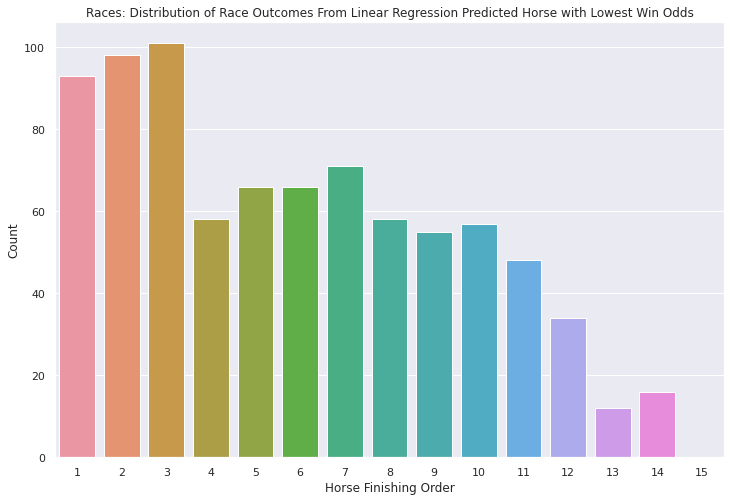

In [ ]:
plt.figure(figsize = (12,8))
plt.title("Races: Distribution of Race Outcomes From Linear Regression Predicted Horse with Lowest Win Odds")
plt.xlabel("Horse Finishing Order")
plt.ylabel("Count")
orderings = list(range(1, 16))
sns.barplot(x=orderings, y=counts)

Now, we try to improve on our existing linear regression model with L1 and L2 regularization techniques. In the code cell below, we create 2 new models, one uses L1 regularization and the other uses L2 regularization.

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

lm1 = linear_model.Lasso(alpha=0.1, normalize=True)
model1 = lm1.fit(x_train, y_train)

lm2 = Ridge(alpha=1.0, normalize=True)
model2 = lm2.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

We perform the same steps as for the initial linear regression model by adding both L1 and L2 predicted average win odd values for each horse into horse_df.

In [ ]:
pred_win_odds_l1 = []
pred_win_odds_l2 = []

for index, horse_row in horse_df.iterrows():
  new_X = [[horse_row["season_stakes"], horse_row["total_stakes"], horse_row["no_starts_in_10"], horse_row["current_rating"], horse_row["sos_rating"], 
            horse_row["no_1"], horse_row["no_2"], horse_row["no_3"], horse_row["no_starts"], horse_row["win_ratio"], horse_row["trainer_rank"]]]
  output = model1.predict(new_X)[0]
  pred_win_odds_l1.append(output)
  output = model2.predict(new_X)[0]
  pred_win_odds_l2.append(output)

horse_df['pred_win_odds_l1'] = pred_win_odds_l1
horse_df['pred_win_odds_l2'] = pred_win_odds_l2

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have 

The updated horse_df is shown in the code cell output below.

In [ ]:
horse_df

,Unnamed: 0,horse_name,horse_url,country_of_origin,age,color,sex,import_type,season_stakes,total_stakes,no_123_starts,no_starts_in_10,trainer,owner,current_rating,sos_rating,retired,no_1,no_2,no_3,no_starts,win_ratio,avg_win_odds,trainer_rank,pred_win_odds,pred_win_odds_l1,pred_win_odds_l2
0,0,JOY MASTER(B222),https://racing.hkjc.com/racing/information/Eng...,AUS,7,Bay,Gelding,PP,124800,2590670,4-1-3-45,2,D E Ferraris,"Fong Chi Keung, Chan Chu Woon & Tam Kin Sang",40,44,False,4,1,3,45,0.088889,11.588889,18,45.123653,40.532044,36.310590
1,1,ART OF RAW(V368),https://racing.hkjc.com/racing/information/Eng...,FR,-1,Bay,Gelding,PP,0,1264425,1-3-1-38,-1,NaN,Mr & Mrs Chan Chi Kong,23,-1,True,1,3,1,38,0.026316,9.220000,36,13.761995,52.293211,54.844076
2,2,THE FULL BLOOM(V243),https://racing.hkjc.com/racing/information/Eng...,GB,-1,NaN,NaN,PP,0,3760725,6-1-5-76,-1,NaN,Gary Lee Sai Ho,20,-1,True,6,1,5,76,0.078947,14.161538,36,12.839556,43.196838,40.020008
3,3,WHO'S HORSE(C233),https://racing.hkjc.com/racing/information/Eng...,NZ,6,Bay,Gelding,PPG,0,225955,0-0-1-19,1,W Y So,Frederick Ma Si Hang & Eric Tsang Chi Wai,17,24,False,0,0,1,19,0.000000,14.783333,13,68.928990,55.129990,54.637489
4,4,GREEN GENERATION(C355),https://racing.hkjc.com/racing/information/Eng...,NZ,-1,Chestnut,Gelding,PPG,0,392875,0-1-1-14,-1,NaN,One More Round Syndicate,27,-1,True,0,1,1,14,0.000000,12.800000,36,16.996931,60.153910,62.928324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,10007,BRILLIANT LIFE(E396),https://racing.hkjc.com/racing/information/Eng...,NZ,4,Brown,Gelding,PP,94200,94200,0-0-0-3,0,C H Yip,Timothy Chan Chi Kin,64,66,False,0,0,0,3,0.000000,87.000000,12,62.690238,55.167237,52.562030
1610,10092,I BELIEVE IN MAGIC(E200),https://racing.hkjc.com/racing/information/Eng...,IRE,4,Bay,Gelding,PPG,0,0,0-0-0-3,2,P O'Sullivan,Kitty Yeung Au Nim Bing,45,51,False,0,0,0,3,0.000000,172.000000,21,69.773801,59.590213,56.569800
1611,10138,SAUVESTRE(E315),https://racing.hkjc.com/racing/information/Eng...,AUS,4,Bay,Gelding,PP,525950,525950,0-1-1-3,1,F C Lor,Jackson So Hoi Wing,71,68,False,0,1,1,3,0.000000,15.000000,0,38.629671,44.189867,42.125728
1612,10167,WIN WIN FIGHTER(E347),https://racing.hkjc.com/racing/information/Eng...,IRE,3,Bay,Gelding,PP,0,0,0-0-0-3,1,K W Lui,Ho Pui Wai,66,70,False,0,0,0,3,0.000000,87.000000,4,56.464436,52.039638,48.782165


Next, we test our L1 and L2 models over the same races and calculate our payout multiplier via the same method as the initial linear regression model above.

In [ ]:
# List of horses that had the lowest, second lowest, third lowest win odds etc.
counts_l1 = [0] * 15;
counts_l2 = [0] * 15;
payout_l1 = 0
payout_l2 = 0

for name, group in race_df.groupby("Date"):
  for name1, group1 in group.groupby("Race No."):
    group1 = group1.sort_values(by="Place", ascending=True)
    lowest_pred_l1 = float("inf")
    lowest_pred_l2 = float("inf")
    i = 0
    place_l1 = 0
    place_l2 = 0

    for index, row in group1.iterrows():
      predict_l1 = horse_df.loc[horse_df["horse_name"] == row["Horse"], "pred_win_odds_l1"].iloc[0]
      predict_l2 = horse_df.loc[horse_df["horse_name"] == row["Horse"], "pred_win_odds_l2"].iloc[0]

      if i == 0:
        winner_odds = row["Win Odds"]

      if predict_l1 < lowest_pred_l1:
        lowest_pred_l1 = predict_l1
        place_l1 = i

      if predict_l2 < lowest_pred_l2:
        lowest_pred_l2 = predict_l2
        place_l2 = i
      
      i += 1

    if place_l1 == 0:
      payout_l1 += winner_odds
    
    if place_l2 == 0:
      payout_l2 += winner_odds

    counts_l1[place_l1] = counts_l1[place_l1] + 1
    counts_l2[place_l2] = counts_l2[place_l2] + 1

print("L1: " + str(counts_l1))
print("L2: " + str(counts_l2))
print("Total Races: " + str(sum(counts)))
print("Total Payout Multiplier L1: " + str(round(payout_l1, 6)))
print("Total Payout Multiplier L2: " + str(round(payout_l2, 6)))

L1: [171, 112, 127, 81, 68, 52, 54, 40, 53, 23, 30, 17, 2, 3, 0]
L2: [163, 111, 127, 77, 71, 56, 49, 47, 52, 23, 30, 20, 4, 3, 0]
Total Races: 833
Total Payout Multiplier L1: 1120.7
Total Payout Multiplier L2: 1130.1


From the code cell output, we can see that adding L1 or L2 regularization drastically improves model performance over the existing linear regression techniques. Here, we can see that our payout multiplier exceeds the number of races that we bet on. Based on the same HK\$10 (US\$1.28) minimum bet strategy used above, our L1 and L2 models would make profits of HK\$2877 (US\$369) and HK\$2971 (US\$381) respectively. In addition, we can see that approximately 50% of horses that our L1 and L2 models select finish in the top 3 positions of the races, marking a significant improvement from our first model.

We now plot the bar chart distribution of the L1 model.

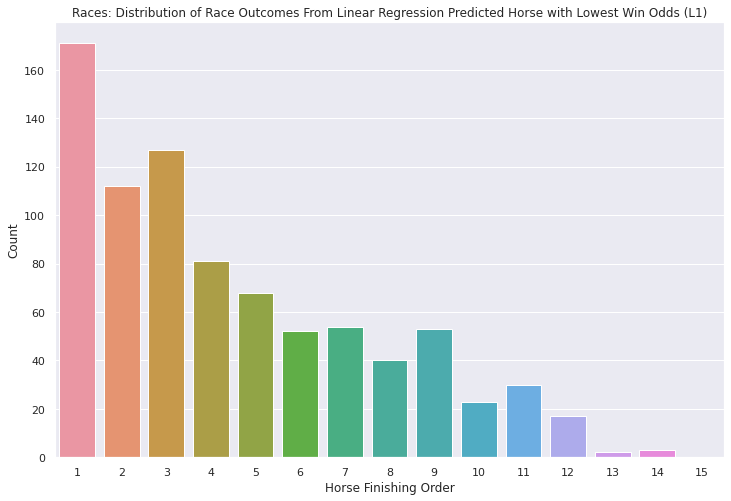

In [ ]:
plt.figure(figsize = (12,8))
plt.title("Races: Distribution of Race Outcomes From Linear Regression Predicted Horse with Lowest Win Odds (L1)")
plt.xlabel("Horse Finishing Order")
plt.ylabel("Count")
orderings = list(range(1, 16))
sns.barplot(x=orderings, y=counts_l1)

We now plot the bar chart distribution of the L2 model.

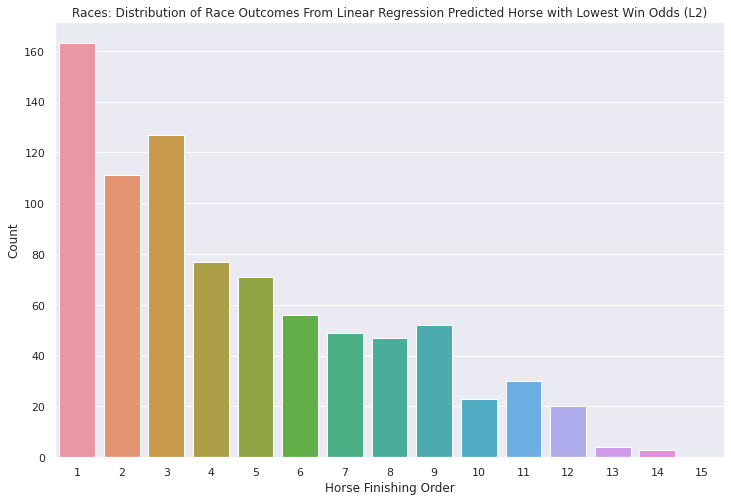

In [ ]:
plt.figure(figsize = (12,8))
plt.title("Races: Distribution of Race Outcomes From Linear Regression Predicted Horse with Lowest Win Odds (L2)")
plt.xlabel("Horse Finishing Order")
plt.ylabel("Count")
orderings = list(range(1, 16))
sns.barplot(x=orderings, y=counts_l2)

From the two plots above, we can see that the shape of the bar chart is more similar to that of the actual race win vs. win odds plot, and that the modal finish positions for our improved models are now both 1st place - which was not the case with the first linear regression model. Therefore, we have shown the effectiveness of L1 and L2 regularization in our project. However, the maximum number of correct predictions we were able to achieve was 171 winners out of 833, significantly lower than the 260 out of 833 predicted by the general public through lowest actual win odds (shown in the EDA section). This means that simply placing a bet on the horse with the lowest actual win odds right before a race is still a superior strategy than placing bets using the lowest regularized linear regression predicted win odds. As such, a more powerful prediction model is needed. 

## Neural Network
From the graphs above, it is clear that although the linear regression strategy can help find horses with high probability of winning, we cannot achieve a sufficient level of accuracy with our model that beats the “human” performance of selecting a horse with lowest win odds on race day. Hence, more powerful tools are required and we will construct a neural network model to predict the outcome of horse races. We first revisit race_df in the code cell below.

In [ ]:
race_df

,Unnamed: 0,Date,Loc.,Race No.,Type,Going,Course,Purse,Place,No.,Horse,Jockey,Trainer,Act. Wt.,Decl. Horse Wt.,Draw,LBW,Running Pos.,Finish Time,Win Odds,Type Class,Type Distance,Type Rating,Max Rating,Min Rating,Pace
0,0,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",1.0,5.0,JOY MASTER(B222),J Moreira,C Fownes,128.0,1070.0,3.0,"""-""",5.500000,95.9,2.6,Class 5,1600.0,(40-0),40.0,0.0,16.684046
1,1,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",2.0,11.0,ART OF RAW(V368),H T Mo,C W Chang,115.0,1085.0,8.0,"""3/4""",1.750000,96.0,13.0,Class 5,1600.0,(40-0),40.0,0.0,16.666667
2,2,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",3.0,10.0,THE FULL BLOOM(V243),K C Leung,C H Yip,119.0,1085.0,1.0,"""1-1/4""",3.500000,96.1,7.3,Class 5,1600.0,(40-0),40.0,0.0,16.649324
3,3,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",4.0,1.0,WHO'S HORSE(C233),K Teetan,K H Ting,133.0,1140.0,6.0,"""1-1/4""",2.000000,96.1,7.2,Class 5,1600.0,(40-0),40.0,0.0,16.649324
4,4,9/6/2020,ST,1,Class 5 - 1600M - (40-0),GOOD,"TURF - ""A"" Course","HK$ 750,000",5.0,7.0,GREEN GENERATION(C355),C Y Ho,C W Chang,126.0,1052.0,7.0,"""1-1/2""",8.750000,96.1,36.0,Class 5,1600.0,(40-0),40.0,0.0,16.649324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10158,10289,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",8.0,2.0,AMAZING ONE PLUS(D173),A Hamelin,T P Yung,130.0,1141.0,10.0,"""3-1/4""",8.000000,69.1,149.0,Class 2,1200.0,(90-70),90.0,70.0,17.366136
10159,10290,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",9.0,1.0,GOLDEN DASH(B190),H Bentley,C S Shum,133.0,1089.0,12.0,"""3-1/4""",10.333333,69.1,57.0,Class 2,1200.0,(90-70),90.0,70.0,17.366136
10160,10291,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",10.0,11.0,WAR WEAPON(E257),K Teetan,C Fownes,114.0,1150.0,1.0,"""4-1/2""",6.000000,69.3,5.4,Class 2,1200.0,(90-70),90.0,70.0,17.316017
10161,10292,7/14/2021,HV,9,Class 2 - 1200M - (90-70),GOOD TO FIRM,"TURF - ""B"" Course","HK$ 2,200,000",11.0,12.0,BABY(C271),V Borges,K H Ting,113.0,1155.0,6.0,"""6-3/4""",8.333333,69.7,40.0,Class 2,1200.0,(90-70),90.0,70.0,17.216643


We are going to select the relevant features for the neural network first. In addition, we must define a race ID to distinguish the races; given that there are 10 races on each date, the race ID will be a concatenation of the date and race no.

In [ ]:
race_df['Race Id'] = race_df['Date'].astype(str) + race_df['Race No.'].astype(str)
new_race_df = race_df[['Race Id', 'Draw', 'Act. Wt.','Decl. Horse Wt.', 'Running Pos.', 'Win Odds', 'Type Distance', 'Max Rating', 'Min Rating', 'Pace', 'Place']]
new_race_df

,Race Id,Draw,Act. Wt.,Decl. Horse Wt.,Running Pos.,Win Odds,Type Distance,Max Rating,Min Rating,Pace,Place
0,9/6/20201,3.0,128.0,1070.0,5.500000,2.6,1600.0,40.0,0.0,16.684046,1.0
1,9/6/20201,8.0,115.0,1085.0,1.750000,13.0,1600.0,40.0,0.0,16.666667,2.0
2,9/6/20201,1.0,119.0,1085.0,3.500000,7.3,1600.0,40.0,0.0,16.649324,3.0
3,9/6/20201,6.0,133.0,1140.0,2.000000,7.2,1600.0,40.0,0.0,16.649324,4.0
4,9/6/20201,7.0,126.0,1052.0,8.750000,36.0,1600.0,40.0,0.0,16.649324,5.0
...,...,...,...,...,...,...,...,...,...,...,...
10158,7/14/20219,10.0,130.0,1141.0,8.000000,149.0,1200.0,90.0,70.0,17.366136,8.0
10159,7/14/20219,12.0,133.0,1089.0,10.333333,57.0,1200.0,90.0,70.0,17.366136,9.0
10160,7/14/20219,1.0,114.0,1150.0,6.000000,5.4,1200.0,90.0,70.0,17.316017,10.0
10161,7/14/20219,6.0,113.0,1155.0,8.333333,40.0,1200.0,90.0,70.0,17.216643,11.0


In order to feed the data into the neural network, we must reconfigure the new_race_df. We decided to move all horses that belong to the same race to one row, so that the columns become `[(Act. Wt., 1), (Decl. Horse Wt., 1), ..., (Act. Wt., 2), (Decl. Horse Wt., 2) ...]`. Ultimately, the last columns are the labels which are the race results for each horse: `[... (Place, 1), (Place, 2), ..., (Place, 14)]`. Finally, for any occasions where there are not 14 horses participating in the race, we fill those columns with null.

In [ ]:
def group_horse_and_result(element):
  if element[0] == 'Place':
      return 100 + element[1] # to make sure results are put near the end
  else:
      return element[1]   
runs_df = new_race_df.pivot(index='Race Id', columns='Draw', values=new_race_df.columns[2:])
rearranged_columns = sorted(list(runs_df.columns.values), key=group_horse_and_result)
runs_df = runs_df[rearranged_columns]

# fill NaNs with 0
runs_df = runs_df.fillna(0)

In [ ]:
print(runs_df.columns)

MultiIndex([(       'Act. Wt.',  1.0),
            ('Decl. Horse Wt.',  1.0),
            (   'Running Pos.',  1.0),
            (       'Win Odds',  1.0),
            (  'Type Distance',  1.0),
            (     'Max Rating',  1.0),
            (     'Min Rating',  1.0),
            (           'Pace',  1.0),
            (       'Act. Wt.',  2.0),
            ('Decl. Horse Wt.',  2.0),
            ...
            (          'Place',  5.0),
            (          'Place',  6.0),
            (          'Place',  7.0),
            (          'Place',  8.0),
            (          'Place',  9.0),
            (          'Place', 10.0),
            (          'Place', 11.0),
            (          'Place', 12.0),
            (          'Place', 13.0),
            (          'Place', 14.0)],
           names=[None, 'Draw'], length=126)


Now, we will split the columns into features and labels. The last 14 columns which are the `places` will be used as the labels. We have 8*14 = 206 features total since we have included 8 features for each horse. Just before we train our model, we perform a 80-20 split on our data to obtain the training and testing sets.

In [ ]:
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
X = runs_df[runs_df.columns[:-14]] 
ss = preprocessing.StandardScaler()
X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)

Y = runs_df[runs_df.columns[-14:]].applymap(lambda x: 1.0 if 0.5 < x < 1.5 else 0.0) 

print(X.shape)
print(Y.shape)

# split data into train and test sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)

(833, 112)
(833, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Finally, we construct the model using Tensorflow!


In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation='relu', input_shape=(112,)),
    tf.keras.layers.Dense(14, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(5e-04),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision(name='precision')])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 96)                10848     
                                                                 
 dense_3 (Dense)             (None, 14)                1358      
                                                                 
Total params: 12,206
Trainable params: 12,206
Non-trainable params: 0
_________________________________________________________________
None


We train the network, test it, and plot the performance.

In [ ]:
import matplotlib.pyplot as plt

dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
train_dataset = dataset.shuffle(len(x_train)).batch(500)
dataset = tf.data.Dataset.from_tensor_slices((x_test.values, y_test.values))
validation_dataset = dataset.shuffle(len(x_test)).batch(500)

print("Start training..\n")
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset)
print("Done!")

Start training..

Epoch 1/200
2/2 [==============================] - 1s 219ms/step - loss: 3.0078 - precision: 0.0000e+00 - val_loss: 2.9379 - val_precision: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 0s 24ms/step - loss: 2.9445 - precision: 0.1000 - val_loss: 2.8990 - val_precision: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 0s 19ms/step - loss: 2.8887 - precision: 0.1250 - val_loss: 2.8642 - val_precision: 0.0000e+00
Epoch 4/200
2/2 [==============================] - 0s 20ms/step - loss: 2.8382 - precision: 0.1333 - val_loss: 2.8320 - val_precision: 0.0000e+00
Epoch 5/200
2/2 [==============================] - 0s 19ms/step - loss: 2.7914 - precision: 0.1538 - val_loss: 2.8025 - val_precision: 0.0000e+00
Epoch 6/200
2/2 [==============================] - 0s 19ms/step - loss: 2.7467 - precision: 0.1538 - val_loss: 2.7758 - val_precision: 0.0000e+00
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 2.7064 - precision: 0.1667 - 

We can see from the code cell output that our neural network model achieves a win prediction precision of 37.84%. That means over a year’s worth of 833 races, our neural network model could theoretically predict approximately 315 winners. This exceeds the “general population” performance benchmark of 260 out of 833 winners.

We plot the training/validation precision and loss of our neural network below.

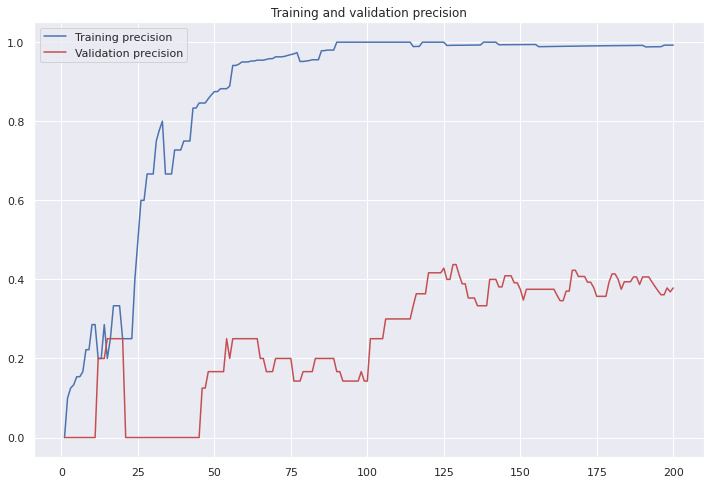

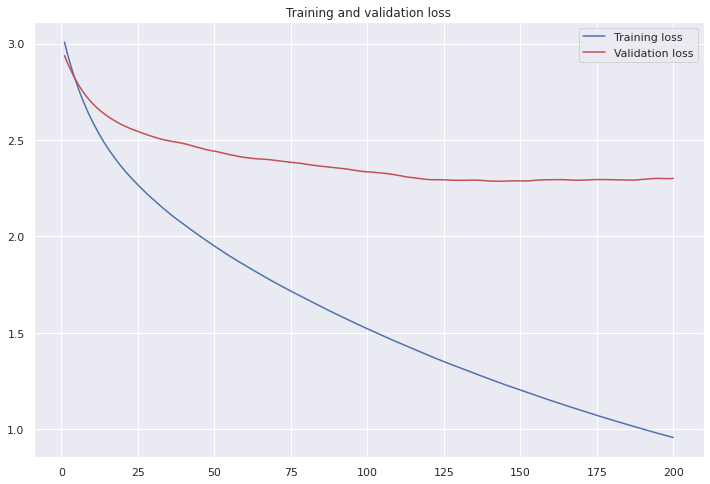

In [ ]:
plt.figure(figsize = (12,8))
precision = history.history['precision']
val_precision = history.history['val_precision']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(precision) + 1)

plt.plot(epochs, precision, 'b', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure(figsize = (12,8))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Conclusion
In conclusion, our team has worked to develop a pipeline from collecting HKJC website data to making horse racing predictions using different models. In the first stage of our project, we were able to find success in our data scraping method by collecting a year’s worth of racing data. Next, we gained important insights into the various factors that affect race outcomes through exploratory data analysis. In our data analysis stage, we first refined a linear regression strategy to pick horses to bet on; however, this model proved to be insufficient as we could not exceed the prediction accuracy of the general population. Following this setback, we decided to develop a neural network model, where we found more success in predicting the winners of horse races. Through this project, we have not only applied various techniques that we have learnt in CIS 545, but also learnt how to apply new techniques in the context big data to help demystify the unpredictability of horse racing.

# Challenges and Obstacles Faced

*   Data collection: the Hong Kong Jockey Club horse racing data was familiar to us; however, it was challenging to figure out how to automate the process of obtaining data from tables listed on the website. Thankfully, we applied what we learned in CIS545, which was using XPATH to extract necessary information from the tables and URLs. And we noticed patterns in the URL that would allow us to filter race data by date, location, and race number, and filter horse data by horse name and ID. We also ran into several obstacles while using the Chrome Driver to visualize the web crawling process since we needed to run the code overnight. However, there were many errors thrown by our code when we were trying to web crawl as various pieces of the data were missing for different tables; hence, we were often forced to repeatedly restart the process in order to continue collecting data throughout several days.
*   Model building: it was even more challenging to determine which columns to keep when building our models. Initially, we included a lot of categorical variables when trying to build our linear regression. However, we had to cut many of those out in order to decrease the mean squared error of the model.  



# Potential Next Steps/Future Direction
There are various aspects of our project that could be explored and developed further. Firstly, we could have explored more data from different years. We had initially planned to obtain data from multiple years, however difficulties with our data scraping method (detailed above) and time limitations restricted us to collecting only a year’s worth of data. 

Furthermore, our neural network model could be made larger, and we could have experimented with models of different depths and activation functions. In addition, our training/validation precision graph showed signs of overfitting in our model. As such, we could also have experimented with various methods to reduce overfitting such as cross validation. 

In addition, many machine learning models to predict horse racing results in Hong Kong actually don’t focus on predicting winners, but combinations and permutations of the top 2/3/4 horses in each race. These predictions are significantly harder, but pay higher dividends. In addition to predicting winners, the HKJC also allows people to place bets on a horse finishing in the top 3 places (with significantly lower payouts), a quinella (1st and 2nd in any order in a race), a quartet (1st, 2nd, 3rd and 4th in correct order in a race) etc. These combinations are notoriously difficult to predict as there are numerous outcomes that can occur, instead of only 14 possible winners attempted in our project. Furthermore, bets can also be placed across races, where people can bet on winners of different races on a race day. As these forms of bets have very high payouts if won, a reasonable strategy is actually to place bets on the n most probable outcomes, instead of just one. Therefore, a future direction could be to explore such betting options to determine the optimal strategy to maximize profit.

Here’s a link showing the different types of bets you can place at the HKJC:
https://is.hkjc.com/AOSBS/help/en/HR_Guide.html

# Thank you! :)